# 模型选择,欠拟合和过拟合
当我们训练模型时,我们只能访问数据中的小部分样本,大部分时候我们只能从数千或者数万个样本中进行学习,当我们使用有限的样本时,我们会遇到这样的问题:**当收集到更多的数据时,会发现之前找到的明显关系并不成立**
将模型在训练数据上拟合的比在潜在分布更接近的现象叫做**过拟合**,用于对抗过拟合的技术称为**正则化**
### 训练误差和泛化误差
> **训练误差**是指模型在训练数据集上得到的误差
>**泛化误差**是指模型应用在同样从原始样本的分布中抽取的无限多样本时,模型误差的期望.
### 统计学习理论
>目前我们在训练数据和测试数据都是从相同的分布中独立提取的,这称作独立同分布假设,意味着对数据进行采样的过程没有进行"**记忆**"
>但是这样的假设是有漏洞的,例如抽样过程可能和时间有关,比如我们在对微博主题进行分类的时候,新闻周期会使得正在讨论的话题产生时间依赖性,从而违反独立性假设.
>有些违反独立性假设,模型仍然运行的很好,例如人脸识别,语音识别,语言翻译等等,这种可能轻微违反独立性假设
>有些违反独立性假设会带来麻烦,例如,我们试图只用大学生的人脸数据来训练一个人脸识别系统,然后用他来监测疗养院中的老人,这可能不太有效
### 模型复杂性
>几个倾向于影响模型泛化的因素:
> - 可调整参数的数量.(当可调整参数的数量很大时,模型容易过拟合)
> - 参数采用的值.(当权重的取值范围较大时,模型可能容易过拟合)
> - 训练样本的数量.(即使模型很简单,也很容易过拟合只包含一两个样本的数据集,而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型.)
### 验证集
>原则上,在我们确定所有的超参数之前,我们不希望用到测试集,如果我们在模型选择的过程中使用测试数据,可能会有过拟合测试数据的风险,那就麻烦大了.如果我们过拟合了训练数据,我们还可以再测试数据上来进行评估是否过拟合,但是如果我们过拟合了测试数据,我们又该怎么知道呢?
>常见做法:将数据分为三份,训练集,测试集,验证数据集(其实好像有套娃的嫌疑,那如果过拟合了验证数据集怎么办,再搞一个验证验证数据集吗?)其实测试集和验证数据集的边界十分模糊
### K折交叉验证、
>当训练数据稀缺时,我们可能无法提供一个足够的验证集
>将原始数据分为K个不重叠的子集,然后执行K次模型训练和验证,每次在K-1个子集上进行训练,并在剩余的一个子集(该轮没有用于训练的子集)上进行验证,最后通过对K次实验的结果取家平均来进行估计训练和验证误差.
### 多项式回归


In [8]:
# 通过多项式拟合来交互地探索这些概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20 # 特征为20就是每一个样本是一个[20,1]的tensor
n_train, n_test = 100, 100 # 100个测试样本、100验证样本
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6]) # 真实标号为5

features = np.random.normal(size=(n_train+n_test,1))
print(features.shape)
np.random.shuffle(features)
print(np.arange(max_degree))
print(np.arange(max_degree).reshape(1,-1))
print(np.power([[10,20]],[[1,2]]))
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1)) # 对第所有维的特征取0次方、1次方、2次方...19次方  
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # i次方的特征除以(i+1)阶乘
labels = np.dot(poly_features,true_w) # 根据多项式生成y，即生成真实的labels
labels += np.random.normal(scale=0.1,size=labels.shape) # 对真实labels加噪音进去

#看一下前两个样本
true_w, features, poly_features, labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w, features, poly_features, labels]]                 
print(features[:2]) # 前两个样本的x
print(poly_features[:2,:]) # 前两个样本的x的所有次方
print(labels[:2])  # 前两个样本的x对应的y

# 实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 两个数的累加器
    for X, y in data_iter: # 从迭代器中拿出对应特征和标签
        out = net(X)
        y = y.reshape(out.shape) # 将真实标签改为网络输出标签的形式，统一形式
        l = loss(out, y) # 计算网络输出的预测值与真实值之间的损失差值
        metric.add(l.sum(), l.numel()) # 总量除以个数，等于平均
    return metric[0] / metric[1] # 返回数据集的平均损失

# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # 单层线性回归
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)    
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])                   
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net,test_iter,loss)))
    print('weight',net[0].weight.data.numpy()) # 训练完后打印，打印最终学到的weight值  


(200, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
[[ 10 400]]
tensor([[ 0.6740],
        [-0.7636]])
tensor([[ 1.0000e+00,  6.7403e-01,  2.2716e-01,  5.1036e-02,  8.6000e-03,
          1.1593e-03,  1.3024e-04,  1.2540e-05,  1.0566e-06,  7.9128e-08,
          5.3335e-09,  3.2681e-10,  1.8357e-11,  9.5175e-13,  4.5822e-14,
          2.0590e-15,  8.6739e-17,  3.4391e-18,  1.2878e-19,  4.5685e-21],
        [ 1.0000e+00, -7.6363e-01,  2.9156e-01, -7.4216e-02,  1.4168e-02,
         -2.1639e-03,  2.7540e-04, -3.0043e-05,  2.8677e-06, -2.4332e-07,
          1.8580e-08, -1.2899e-09,  8.2082e-11, -4.8215e-12,  2.6299e-13,
         -1.3388e-14,  6.3899e-16, -2.8703e-17,  1.2177e-18, -4.8940e-20]])
tensor([5.2168, 2.4261])


weight [[ 4.9963703  1.1790373 -3.3969595  5.6243463]]


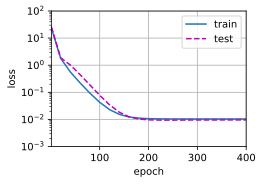

In [9]:
# 三阶多项式函数拟合(正态)
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])  # 最后返回的weight值和公式真实weight值很接近       

weight [[3.597754  3.8033888]]


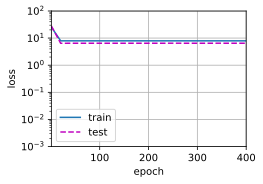

In [13]:
# 一阶多项式函数拟合(欠拟合)
# 这里相当于用一阶多项式拟合真实的三阶多项式，但我并没有看到欠拟合
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

weight [[ 4.961512    1.3026638  -3.195162    4.94802    -0.5101665   1.7533833
  -0.06415471  0.36068848  0.1998085  -0.13432275 -0.19940357 -0.11681005
  -0.02602248 -0.06197245  0.0475579   0.1617776   0.05029725  0.08914328
   0.19846287 -0.19565666]]


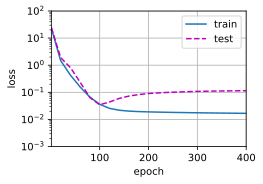

In [11]:
# 十九阶多项式函数拟合(过拟合)
# 这里相当于用十九阶多项式拟合真实的三阶多项式，过拟合了
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])